# exp003

In [106]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb

sns.set_style("darkgrid")
%matplotlib inline

## データセットの読み込み

In [107]:
input_path = Path("../input")

train_df = pd.read_parquet(input_path / "train.parquet")
test_df = pd.read_parquet(input_path / "test.parquet")

## RMSLEの定義

In [108]:
def feval_rmsle(preds, data):
    y_true = data.get_label()
    preds = np.clip(preds, 0, None)  # 0より小さい値を0に置換
    rmsle = np.sqrt(mean_squared_log_error(y_true, preds))
    return 'RMSLE', rmsle, False

## 特徴量エンジニアリング

In [109]:
df = pd.concat([train_df, test_df], axis=0, sort=False).reset_index(drop=True)
df = df.drop(["casual", "registered"], axis=1)
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1.0
...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN


In [110]:
datetime = pd.to_datetime(df["datetime"])
df["year"] = datetime.dt.year
df["month"] = datetime.dt.month
df["day"] = datetime.dt.day
df["hour"] = datetime.dt.hour
df["dayofweek"] = datetime.dt.day_name()
df["dayofweek"] = df["dayofweek"].map({"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6})
df = df.drop("datetime", axis=1)
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0000,16.0,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0000,40.0,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0000,32.0,2011,1,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0000,13.0,2011,1,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0000,1.0,2011,1,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,1,2,10.66,12.880,60,11.0014,NaN,2012,12,31,19,0
17375,1,0,1,2,10.66,12.880,60,11.0014,NaN,2012,12,31,20,0
17376,1,0,1,1,10.66,12.880,60,11.0014,NaN,2012,12,31,21,0
17377,1,0,1,1,10.66,13.635,56,8.9981,NaN,2012,12,31,22,0


In [111]:
train_df = df[~df["count"].isnull()].reset_index(drop=True)
test_df = df[df["count"].isnull()].drop("count", axis=1).reset_index(drop=True)

## train

In [112]:
def train(df, model_path):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_rmsles = []

    for fold, (train_index, valid_index) in enumerate(kf.split(df)):
        print(f"start training for fold {fold}")

        X_train = df.iloc[train_index].drop(["count"], axis=1)
        y_train = df.iloc[train_index]["count"]

        X_valid = df.iloc[valid_index].drop(["count"], axis=1)
        y_valid = df.iloc[valid_index]["count"]

        print("start training")
        params = {
            "objective": "regression",
            "seed": 42,
            "learning_rate": 0.01,
            "num_leaves": 32,
        }

        train_set = lgb.Dataset(X_train, y_train)
        valid_set = lgb.Dataset(X_valid, y_valid, reference=train_set)

        model = lgb.train(
            params=params,
            train_set=train_set,
            valid_sets=[train_set, valid_set],
            num_boost_round=10000,
            feval=feval_rmsle,
            callbacks=[
                lgb.early_stopping(stopping_rounds=10, verbose=True),
                lgb.log_evaluation(period=10)
            ]
        )

        print(f"predict valid for fold {fold}")
        y_pred = model.predict(X_valid)
        y_pred = np.clip(y_pred, 0, None)

        fold_rmsles.append(np.sqrt(mean_squared_log_error(y_valid, y_pred)))

        print(f"save model for fold {fold}")
        model.save_model(model_path / f"model_fold{fold+1:03d}.bin", num_iteration=model.best_iteration)

    return sum(fold_rmsles) / len(fold_rmsles)

In [113]:
model_path = Path("../output/model003")

train_rmsle = train(train_df, model_path)
print(f"RMSLE: {train_rmsle}")

start training for fold 0
start training
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 13
[LightGBM] [Info] Start training from score 191.584750
Training until validation scores don't improve for 10 rounds
[10]	training's l2: 28078.3	training's RMSLE: 1.51114	valid_1's l2: 28343.7	valid_1's RMSLE: 1.53408
[20]	training's l2: 24177.7	training's RMSLE: 1.46235	valid_1's l2: 24438.5	valid_1's RMSLE: 1.48548
[30]	training's l2: 20971.1	training's RMSLE: 1.41699	valid_1's l2: 21208.1	valid_1's RMSLE: 1.44028
[40]	training's l2: 18289.6	training's RMSLE: 1.37415	valid_1's l2: 18495.2	valid_1's RMSLE: 1.39761
[50]	training's l2: 16046.9	training's RMSLE: 1.3336	valid_1's l2: 16222.6	valid_1's RMSLE: 1.35723
[60]	training's l2: 14170	training's RMSLE: 1.29501	

## evaluate

In [119]:
def evaluate(df, model_path):
    predictions = []

    for fold in range(5):
        print(f"loading model for fold {fold}")
        model = lgb.Booster(model_file=model_path / f"model_fold{fold+1:03d}.bin")

        print(f"start evaluate for fold {fold}")
        X_test = df.copy()

        print(f"predict test for fold {fold}")
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred = np.clip(y_pred, 0, None)
        predictions.append(y_pred)
    
    average_predictions = np.mean(predictions, axis=0)
    return average_predictions

In [120]:
y_pred = evaluate(test_df, model_path)
y_pred

loading model for fold 0
start evaluate for fold 0
predict test for fold 0
loading model for fold 1
start evaluate for fold 1
predict test for fold 1
loading model for fold 2
start evaluate for fold 2
predict test for fold 2
loading model for fold 3
start evaluate for fold 3
predict test for fold 3
loading model for fold 4
start evaluate for fold 4
predict test for fold 4


array([ 14.68089565,   6.76358462,   3.97099437, ..., 123.61753269,
        91.00043642,  59.64059941])

In [121]:
submission = pd.read_csv(input_path / "sampleSubmission.csv")
submission["count"] = y_pred
submission.to_csv("../output/submission003.csv", index=False)

## Result

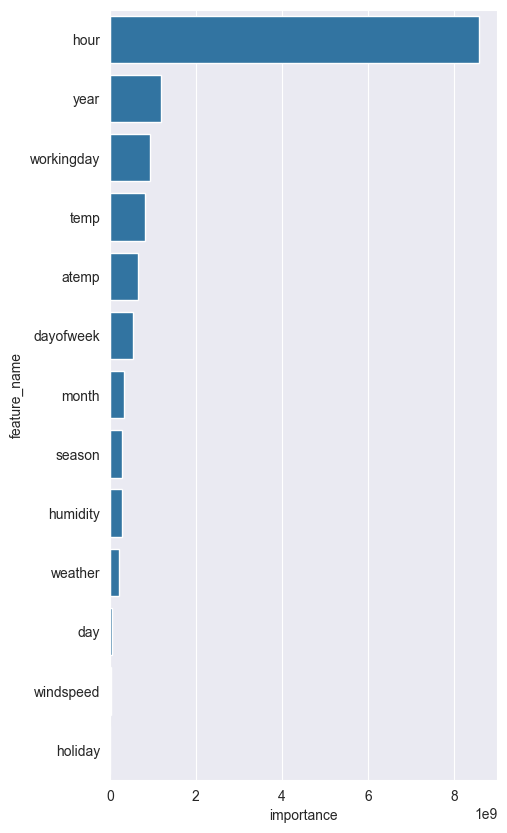

In [122]:
model = lgb.Booster(model_file=model_path / f"model_fold001.bin")
importance_df = pd.DataFrame()

importance_df["importance"] = model.feature_importance(importance_type="gain")
importance_df["feature_name"] = model.feature_name()
importance_df = importance_df.sort_values("importance", ascending=False)

fig = plt.figure(figsize=(5, 10))
sns.barplot(data=importance_df, x="importance", y="feature_name")
plt.show()